# 31 - Analysis Plots

This notebook creates visualizations of experimental results:
- Disk usage comparisons
- Training throughput comparisons
- Batch size scaling curves
- Worker scaling curves
- Resource utilization heatmaps

**Output:**
- Publication-quality plots
- Saved to `reports/figures/`

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Load common utilities
%run ./10_common_utils.ipynb

✓ Common utilities loaded successfully

Available functions:
  - set_seed(seed)
  - get_transforms(augment)
  - write_sysinfo(path)
  - time_first_batch(dataloader, device)
  - start_monitor(log_path, interval)
  - stop_monitor(thread, stop_event)
  - append_to_summary(path, row_dict)
  - compute_metrics_from_logs(log_path)
  - get_device()
  - format_bytes(bytes)
  - count_parameters(model)

Constants:
  - STANDARD_TRANSFORM


## Configuration

In [3]:
# Detect environment
IS_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ
BASE_DIR = Path('/kaggle/working/format-matters') if IS_KAGGLE else Path('..').resolve()

REPORT_DIR = BASE_DIR / 'reports'
FIGURES_DIR = REPORT_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Environment: {'Kaggle' if IS_KAGGLE else 'Local'}")
print(f"Figures directory: {FIGURES_DIR}")

# Color palette for formats
FORMAT_COLORS = {
    'csv': '#e74c3c',
    'webdataset': '#3498db',
    'tfrecord': '#2ecc71',
    'lmdb': '#f39c12',
}

Environment: Local
Figures directory: C:\Users\arjya\Fall 2025\Systems for ML\Project 1\SML\format-matters\reports\figures


## Load Summary Data

In [4]:
# Load exported summaries
builds_df = None
train_df = None
scaling_df = None

if (REPORT_DIR / 'builds_summary.csv').exists():
    builds_df = pd.read_csv(REPORT_DIR / 'builds_summary.csv')
    print(f"✓ Loaded builds summary: {len(builds_df)} rows")

if (REPORT_DIR / 'training_summary.csv').exists():
    train_df = pd.read_csv(REPORT_DIR / 'training_summary.csv')
    print(f"✓ Loaded training summary: {len(train_df)} rows")

if (REPORT_DIR / 'scaling_summary.csv').exists():
    scaling_df = pd.read_csv(REPORT_DIR / 'scaling_summary.csv')
    print(f"✓ Loaded scaling summary: {len(scaling_df)} rows")

✓ Loaded builds summary: 16 rows
✓ Loaded training summary: 4 rows


## 1. Disk Usage Comparison

✓ Saved: C:\Users\arjya\Fall 2025\Systems for ML\Project 1\SML\format-matters\reports\figures\disk_usage.png


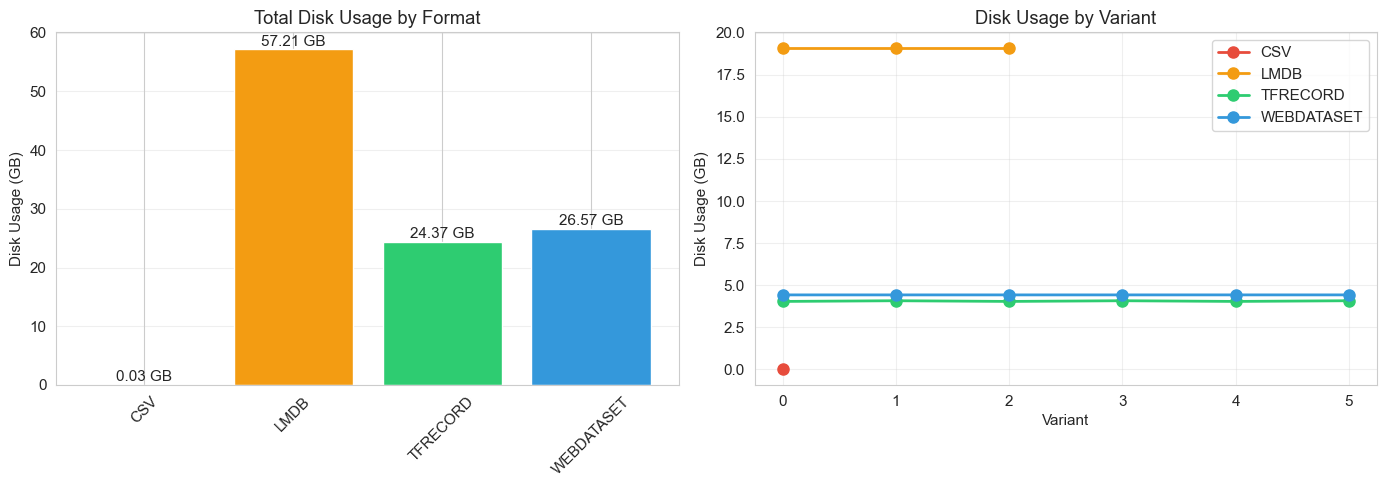

In [5]:
if builds_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total disk usage by format
    total_by_format = builds_df.groupby('format')['bytes_on_disk'].sum() / (1024**3)  # Convert to GB
    colors = [FORMAT_COLORS.get(fmt, '#95a5a6') for fmt in total_by_format.index]
    
    ax1.bar(range(len(total_by_format)), total_by_format.values, color=colors)
    ax1.set_xticks(range(len(total_by_format)))
    ax1.set_xticklabels([fmt.upper() for fmt in total_by_format.index], rotation=45)
    ax1.set_ylabel('Disk Usage (GB)')
    ax1.set_title('Total Disk Usage by Format')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(total_by_format.values):
        ax1.text(i, v + 0.1, f'{v:.2f} GB', ha='center', va='bottom')
    
    # Disk usage by variant
    for format_name in builds_df['format'].unique():
        format_data = builds_df[builds_df['format'] == format_name]
        sizes = format_data['bytes_on_disk'] / (1024**3)
        variants = format_data['variant']
        
        ax2.plot(range(len(variants)), sizes.values, 
                marker='o', label=format_name.upper(), 
                color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                linewidth=2, markersize=8)
    
    ax2.set_xlabel('Variant')
    ax2.set_ylabel('Disk Usage (GB)')
    ax2.set_title('Disk Usage by Variant')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'disk_usage.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {FIGURES_DIR / 'disk_usage.png'}")
    plt.show()
else:
    print("⚠ No build data available for plotting")

## 2. Training Throughput Comparison

✓ Saved: C:\Users\arjya\Fall 2025\Systems for ML\Project 1\SML\format-matters\reports\figures\training_throughput.png


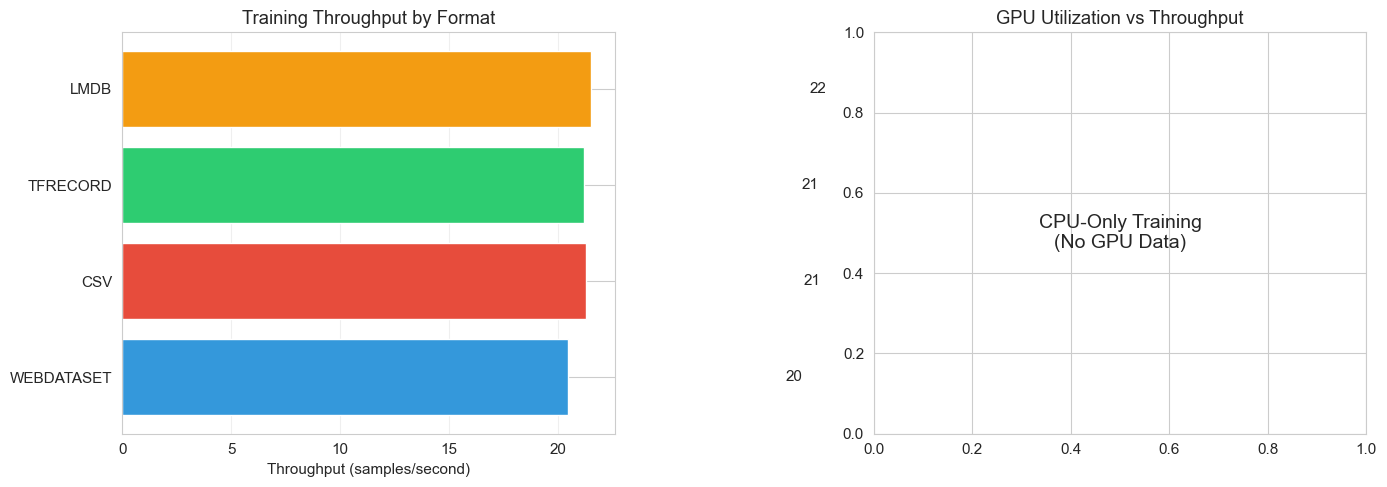

In [6]:
if train_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Throughput comparison
    formats = train_df['format'].values
    throughputs = train_df['train_samples_per_sec'].values
    colors = [FORMAT_COLORS.get(fmt, '#95a5a6') for fmt in formats]
    
    bars = ax1.barh(range(len(formats)), throughputs, color=colors)
    ax1.set_yticks(range(len(formats)))
    ax1.set_yticklabels([fmt.upper() for fmt in formats])
    ax1.set_xlabel('Throughput (samples/second)')
    ax1.set_title('Training Throughput by Format')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(throughputs):
        ax1.text(v + 10, i, f'{v:.0f}', va='center')
    
    # GPU utilization vs throughput (only if GPU data available)
    if 'gpu_util_mean' in train_df.columns:
        gpu_values = train_df['gpu_util_mean'].dropna()
        if len(gpu_values) > 0:
            for format_name in train_df['format'].unique():
                format_data = train_df[train_df['format'] == format_name]
                # Only plot if GPU data is available
                if format_data['gpu_util_mean'].notna().any():
                    ax2.scatter(format_data['gpu_util_mean'], 
                               format_data['train_samples_per_sec'],
                               s=200, alpha=0.7,
                               color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                               label=format_name.upper())
            
            ax2.set_xlabel('GPU Utilization (%)')
            ax2.set_ylabel('Throughput (samples/second)')
            ax2.set_title('GPU Utilization vs Throughput')
            ax2.legend()
            ax2.grid(alpha=0.3)
        else:
            # CPU-only training
            ax2.text(0.5, 0.5, 'CPU-Only Training\n(No GPU Data)', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=14)
            ax2.set_title('GPU Utilization vs Throughput')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'training_throughput.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {FIGURES_DIR / 'training_throughput.png'}")
    plt.show()
else:
    print("⚠ No training data available for plotting")

## 3. Batch Size Scaling

In [7]:
if scaling_df is not None:
    # Filter for fixed workers
    batch_scaling = scaling_df[scaling_df['num_workers'] == 4]
    
    if not batch_scaling.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Throughput vs batch size
        for format_name in batch_scaling['format'].unique():
            format_data = batch_scaling[batch_scaling['format'] == format_name].sort_values('batch_size')
            
            ax1.plot(format_data['batch_size'], format_data['samples_per_sec'],
                    marker='o', label=format_name.upper(),
                    color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                    linewidth=2, markersize=8)
        
        ax1.set_xlabel('Batch Size')
        ax1.set_ylabel('Throughput (samples/second)')
        ax1.set_title('Batch Size Scaling (4 workers)')
        ax1.legend()
        ax1.grid(alpha=0.3)
        ax1.set_xscale('log', base=2)
        
        # GPU utilization vs batch size (only if GPU data available)
        if 'gpu_util_mean' in batch_scaling.columns:
            gpu_values = batch_scaling['gpu_util_mean'].dropna()
            if len(gpu_values) > 0:
                for format_name in batch_scaling['format'].unique():
                    format_data = batch_scaling[batch_scaling['format'] == format_name].sort_values('batch_size')
                    
                    ax2.plot(format_data['batch_size'], format_data['gpu_util_mean'],
                            marker='s', label=format_name.upper(),
                            color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                            linewidth=2, markersize=8)
                
                ax2.set_xlabel('Batch Size')
                ax2.set_ylabel('GPU Utilization (%)')
                ax2.set_title('GPU Utilization vs Batch Size')
                ax2.legend()
                ax2.grid(alpha=0.3)
                ax2.set_xscale('log', base=2)
            else:
                # No GPU data
                ax2.text(0.5, 0.5, 'CPU-Only Training\n(No GPU Data)', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=14)
                ax2.set_title('GPU Utilization vs Batch Size')
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'batch_size_scaling.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {FIGURES_DIR / 'batch_size_scaling.png'}")
        plt.show()
    else:
        print("⚠ No batch scaling data available")
else:
    print("⚠ No scaling data available for plotting")

⚠ No scaling data available for plotting


## 4. Worker Scaling

In [8]:
if scaling_df is not None:
    # Filter for fixed batch size
    worker_scaling = scaling_df[scaling_df['batch_size'] == 64]
    
    if not worker_scaling.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Throughput vs workers
        for format_name in worker_scaling['format'].unique():
            format_data = worker_scaling[worker_scaling['format'] == format_name].sort_values('num_workers')
            
            ax1.plot(format_data['num_workers'], format_data['samples_per_sec'],
                    marker='o', label=format_name.upper(),
                    color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                    linewidth=2, markersize=8)
        
        ax1.set_xlabel('Number of Workers')
        ax1.set_ylabel('Throughput (samples/second)')
        ax1.set_title('Worker Scaling (batch size 64)')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # CPU utilization vs workers
        if 'cpu_util_mean' in worker_scaling.columns:
            for format_name in worker_scaling['format'].unique():
                format_data = worker_scaling[worker_scaling['format'] == format_name].sort_values('num_workers')
                
                ax2.plot(format_data['num_workers'], format_data['cpu_util_mean'],
                        marker='s', label=format_name.upper(),
                        color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                        linewidth=2, markersize=8)
            
            ax2.set_xlabel('Number of Workers')
            ax2.set_ylabel('CPU Utilization (%)')
            ax2.set_title('CPU Utilization vs Workers')
            ax2.legend()
            ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'worker_scaling.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {FIGURES_DIR / 'worker_scaling.png'}")
        plt.show()
    else:
        print("⚠ No worker scaling data available")
else:
    print("⚠ No scaling data available for plotting")

⚠ No scaling data available for plotting


## 5. Resource Utilization Heatmap

✓ Saved: C:\Users\arjya\Fall 2025\Systems for ML\Project 1\SML\format-matters\reports\figures\resource_utilization.png


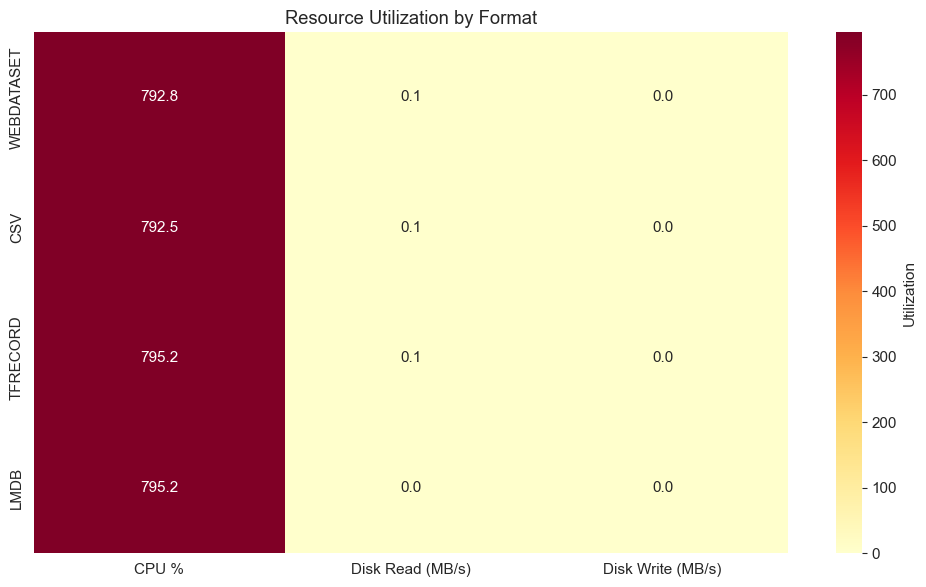

In [9]:
if train_df is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for heatmap
    metrics = ['cpu_util_mean', 'disk_read_mb_s_mean', 'disk_write_mb_s_mean']
    
    # Only include GPU if data is available
    if 'gpu_util_mean' in train_df.columns and train_df['gpu_util_mean'].notna().any():
        metrics.insert(0, 'gpu_util_mean')
    
    available_metrics = [m for m in metrics if m in train_df.columns]
    
    if available_metrics:
        heatmap_data = train_df[['format'] + available_metrics].set_index('format')
        heatmap_data.index = [idx.upper() for idx in heatmap_data.index]
        
        # Rename columns for display
        column_names = {
            'gpu_util_mean': 'GPU %',
            'cpu_util_mean': 'CPU %',
            'disk_read_mb_s_mean': 'Disk Read (MB/s)',
            'disk_write_mb_s_mean': 'Disk Write (MB/s)'
        }
        heatmap_data = heatmap_data.rename(columns=column_names)
        
        # Create heatmap
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                    cbar_kws={'label': 'Utilization'}, ax=ax)
        ax.set_title('Resource Utilization by Format')
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'resource_utilization.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {FIGURES_DIR / 'resource_utilization.png'}")
        plt.show()
    else:
        print("⚠ No resource utilization data available")
else:
    print("⚠ No training data available for resource utilization heatmap")

## 6. Summary Dashboard

✓ Saved: C:\Users\arjya\Fall 2025\Systems for ML\Project 1\SML\format-matters\reports\figures\dashboard.png


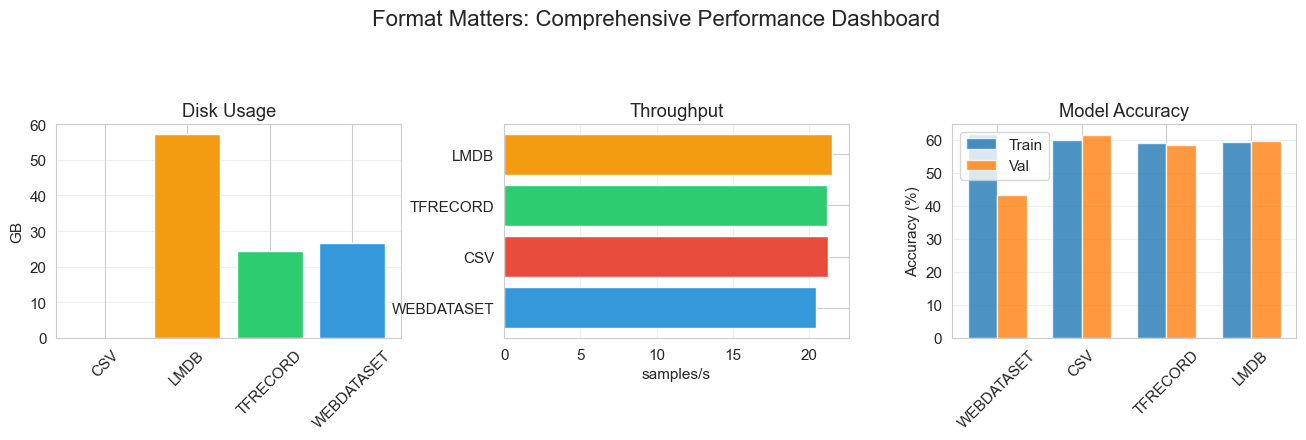

In [10]:
if train_df is not None and builds_df is not None:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Disk usage
    ax1 = fig.add_subplot(gs[0, 0])
    total_by_format = builds_df.groupby('format')['bytes_on_disk'].sum() / (1024**3)
    colors = [FORMAT_COLORS.get(fmt, '#95a5a6') for fmt in total_by_format.index]
    ax1.bar(range(len(total_by_format)), total_by_format.values, color=colors)
    ax1.set_xticks(range(len(total_by_format)))
    ax1.set_xticklabels([fmt.upper() for fmt in total_by_format.index], rotation=45)
    ax1.set_ylabel('GB')
    ax1.set_title('Disk Usage')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Throughput
    ax2 = fig.add_subplot(gs[0, 1])
    formats = train_df['format'].values
    throughputs = train_df['train_samples_per_sec'].values
    colors = [FORMAT_COLORS.get(fmt, '#95a5a6') for fmt in formats]
    ax2.barh(range(len(formats)), throughputs, color=colors)
    ax2.set_yticks(range(len(formats)))
    ax2.set_yticklabels([fmt.upper() for fmt in formats])
    ax2.set_xlabel('samples/s')
    ax2.set_title('Throughput')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Accuracy
    ax3 = fig.add_subplot(gs[0, 2])
    train_acc = train_df['train_acc'].values
    val_acc = train_df['val_acc'].values
    x = np.arange(len(formats))
    width = 0.35
    ax3.bar(x - width/2, train_acc, width, label='Train', alpha=0.8)
    ax3.bar(x + width/2, val_acc, width, label='Val', alpha=0.8)
    ax3.set_xticks(x)
    ax3.set_xticklabels([fmt.upper() for fmt in formats], rotation=45)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Model Accuracy')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4-6. Batch scaling (if available)
    if scaling_df is not None:
        batch_scaling = scaling_df[scaling_df['num_workers'] == 4]
        if not batch_scaling.empty:
            ax4 = fig.add_subplot(gs[1, :])
            for format_name in batch_scaling['format'].unique():
                format_data = batch_scaling[batch_scaling['format'] == format_name].sort_values('batch_size')
                ax4.plot(format_data['batch_size'], format_data['samples_per_sec'],
                        marker='o', label=format_name.upper(),
                        color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                        linewidth=2, markersize=8)
            ax4.set_xlabel('Batch Size')
            ax4.set_ylabel('Throughput (samples/s)')
            ax4.set_title('Batch Size Scaling')
            ax4.legend()
            ax4.grid(alpha=0.3)
            ax4.set_xscale('log', base=2)
        
        worker_scaling = scaling_df[scaling_df['batch_size'] == 64]
        if not worker_scaling.empty:
            ax5 = fig.add_subplot(gs[2, :])
            for format_name in worker_scaling['format'].unique():
                format_data = worker_scaling[worker_scaling['format'] == format_name].sort_values('num_workers')
                ax5.plot(format_data['num_workers'], format_data['samples_per_sec'],
                        marker='o', label=format_name.upper(),
                        color=FORMAT_COLORS.get(format_name, '#95a5a6'),
                        linewidth=2, markersize=8)
            ax5.set_xlabel('Number of Workers')
            ax5.set_ylabel('Throughput (samples/s)')
            ax5.set_title('Worker Scaling')
            ax5.legend()
            ax5.grid(alpha=0.3)
    
    plt.suptitle('Format Matters: Comprehensive Performance Dashboard', fontsize=16, y=0.995)
    plt.savefig(FIGURES_DIR / 'dashboard.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {FIGURES_DIR / 'dashboard.png'}")
    plt.show()
else:
    print("⚠ Insufficient data for dashboard")

## ✅ Visualization Complete

**Plots created:**
- Disk usage comparison
- Training throughput comparison
- Batch size scaling curves
- Worker scaling curves
- Resource utilization heatmap
- Comprehensive dashboard

**All figures saved to:** `reports/figures/`

**Next step:**
- Generate decision guide (40_decision_guide.ipynb)